## Importing the relevant libraries

In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import all the necessary model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, Lambda, Input, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from keras import regularizers
from tensorflow.keras.models import Model

from IPython.display import display, Image
import time

from tensorflow.keras.applications import Xception

In [3]:
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True

COLAB_FILEPATH = './drive/My Drive/4041-dog-breed-classification/' if COLAB_FLAG == True else './'
%matplotlib inline

In [4]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


## Import the numpy (.npz) file consisting our training images
* [np.save()](https://numpy.org/doc/stable/reference/generated/numpy.save.html)
* [np.savez()](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)
* [np.savez_compressed()](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html)
* [np.lib.format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)

In [5]:
INPUT_SHAPE = (128,128,3)
NPZ_PATH = f'{COLAB_FILEPATH}Datasets/preprocessed_data_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'

In [6]:
# loading the npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH)
print(loaded.files)
loaded_X = loaded["X"]
loaded_Y = loaded["Y"]
print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X', 'Y']
Time taken to load compressed data: 11.174952507019043


In [8]:
# check the numpy array information and the size conversion
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def nparray_info(header, nparr):
    print(header)
    print("-  shape\t", nparr.shape)
    print("-  dtype\t", nparr.dtype)
    print("- nbytes\t", f"{nparr.nbytes} ({convert_size(nparr.nbytes)})")

In [9]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X)
print()
nparray_info("Labels (npz)", loaded_Y)

Images (npz)
-  shape	 (10222, 128, 128, 3)
-  dtype	 float16
- nbytes	 1004863488 (958.31 MB)

Labels (npz)
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [10]:
# check the numpy array values whether is it normalised or not
loaded_X[50][0][:7]

array([[0.6157, 0.565 , 0.498 ],
       [0.4158, 0.3647, 0.298 ],
       [0.306 , 0.251 , 0.2079],
       [0.2354, 0.1843, 0.149 ],
       [0.2313, 0.1804, 0.1569],
       [0.4158, 0.3608, 0.349 ],
       [0.2313, 0.204 , 0.1726]], dtype=float16)

In [11]:
loaded_Y[50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [12]:
# get the respective labels
# loading labels from csv file
df = pd.read_csv(f"{COLAB_FILEPATH}Datasets/labels.csv")

# create dictionary of unique breeds with its respective id
breeds = df.breed.unique()
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
df["breed_id"] = df.breed
# convert duplicated column as unique id
df = df.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(df.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


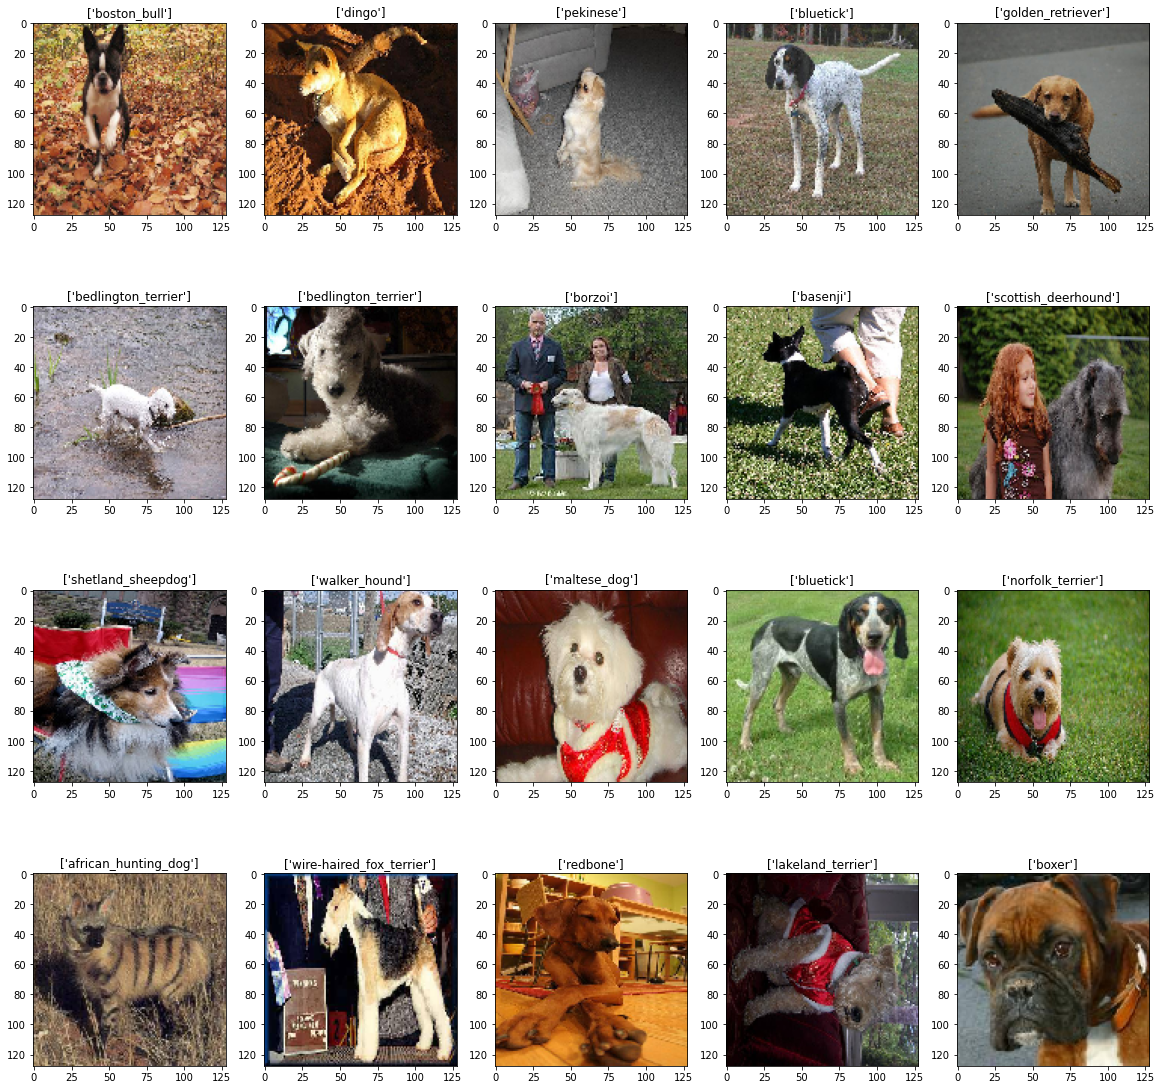

In [13]:
# check the data
N = 20

plt.figure(figsize=(20,20))
for i in range(N):
    ax = plt.subplot(int(N/5),5,i+1)
    plt.title(breeds[np.where(loaded_Y[i]==1)[0]])
    plt.imshow(loaded_X[i].astype('float32'))

## Split data into train and val

In [14]:
# perform train test split to get training and validation data
X_train, X_val, y_train, y_val = train_test_split(loaded_X, loaded_Y, train_size=0.8,random_state=42)

## Image Augmentation

In [15]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest"
)

# Model Building

In [27]:
# for plotting
def plot_model_history(history, folder=COLAB_FILEPATH+"plots/", saving_name="model_loss_accuracy"):
    plt.style.use("ggplot")
    plt.figure(figsize=(16, 6))

    # plot for loss
    ax = plt.subplot(1, 2, 1)
    # ensure ploting never plot beyond 10
    #y_max = (max(history.history["loss"]), max(history.history["val_loss"]))
    #y_max = min(10.0, max(y_max))
    #ax.set_ylim(ymax=y_max)
    plt.plot( history.history["loss"], label="train_loss")
    plt.plot( history.history["val_loss"], label="val_loss")

    plt.title(f"Model Loss - {saving_name}")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # plot for accuracy
    ax = plt.subplot(1, 2, 2)
    ax.set_ylim([0,1]) # fix y-range for eazy comparison 
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")

    plt.title(f"Model Accuracy - {saving_name}")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name+'.jpg')
    plt.show()

def plot_learning_rate(history, folder="plots/", saving_name="model_learn_rate"):
    # history only contain lr when lrScheduler used 
    #assert('lr' in history.history.keys()), "model history does not contain lr, ensure lr related callback is used"
    
    # the learning rate schedule
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 6))
    plt.plot( history.history["lr"], label="learn rate")
    plt.title("Learning Rate")
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")
    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name)
    plt.show()

In [17]:
# hyperparameters
BATCH_SIZE = 128
EPOCHS = 50
ALPHA = 0.001
sgd = SGD(lr=ALPHA,momentum=0.9)
adam = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999)

# model description
MODEL_NAME = 'Xception'

In [18]:
# initialise saved weights filename
FILENAME = f'{MODEL_NAME}_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}_bs-{BATCH_SIZE}_lr-{ALPHA}'

In [19]:
# define callbacks
saved_weights = ModelCheckpoint(filepath=f'{COLAB_FILEPATH}Datasets/{FILENAME}.h5',save_best_only=True,verbose=1)
reduced_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
# retrieve base model
base = Xception(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

# freeze pre-trained weight
# base.trainable = False

# rebuild output layer
x = base.output
x = GlobalAveragePooling2D()(x)
head = Dense(120, activation='softmax')(x)
model = Model(inputs=base.input, outputs=head)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [21]:
# Compiling the model
model.compile(optimizer=adam, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [22]:
# train model
H = model.fit(train_datagen.flow(X_train,y_train,
                                 batch_size=BATCH_SIZE,
                                 #seed=4041,
                                 shuffle=True),
              epochs=EPOCHS,
              steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
              validation_data=(X_val,y_val),
              callbacks=[saved_weights, reduced_lr, early_stopping]
              )

Epoch 1/50
63/63 [==============================] - 116s 2s/step - loss: 4.0415 - accuracy: 0.1330 - val_loss: 4.3636 - val_accuracy: 0.1746

Epoch 00001: val_loss improved from inf to 4.36360, saving model to ./drive/My Drive/4041-dog-breed-classification/Datasets/Xception_128x128_bs-128_lr-0.001.h5
Epoch 2/50
63/63 [==============================] - 101s 2s/step - loss: 1.7157 - accuracy: 0.5203 - val_loss: 2.7108 - val_accuracy: 0.3330

Epoch 00002: val_loss improved from 4.36360 to 2.71077, saving model to ./drive/My Drive/4041-dog-breed-classification/Datasets/Xception_128x128_bs-128_lr-0.001.h5
Epoch 3/50
63/63 [==============================] - 102s 2s/step - loss: 1.0986 - accuracy: 0.6871 - val_loss: 2.6247 - val_accuracy: 0.3369

Epoch 00003: val_loss improved from 2.71077 to 2.62471, saving model to ./drive/My Drive/4041-dog-breed-classification/Datasets/Xception_128x128_bs-128_lr-0.001.h5
Epoch 4/50
63/63 [==============================] - 101s 2s/step - loss: 0.7336 - accu

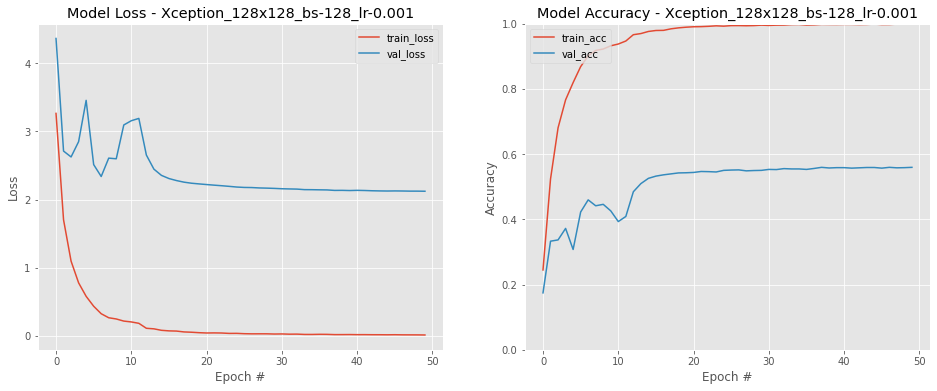

In [28]:
# plot model performance
plot_model_history(H, saving_name=FILENAME)